In [134]:
%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
from viz import NetworkView
import matplotlib.pyplot as plt
from networks import DiscourseNetworks
import community

# Reading dna-party dataset

In [135]:
# This dataset has been created by Caroline Bhattacharya
data = pd.read_csv('../dataset/dna-party-dataset.csv', sep=",")

# Rows in dataset
data

,statement ID,time,document ID,document type,text,mp,party,concept,agreement,category
0,480,2010-05-07,2,EoV,"Mir ist bewusst, dass es inzwischen unausweich...","Aschenberg-Dugnus, Christine",FDP,Aid_Currency stabilisation,1,Policy
1,479,2010-05-07,2,EoV,Die von der Bundesregierung nun eingeleiteten ...,"Aschenberg-Dugnus, Christine",FDP,Crisis_Contagion,1,Polity
2,2,2010-05-07,2,EoV,Die von der Bundesregierung nun eingeleiteten ...,"Aschenberg-Dugnus, Christine",FDP,Alternatives,0,Politics
3,482,2010-05-07,2,EoV,"Gleichwohl ist daran zu erinnern, dass zunäch...","Aschenberg-Dugnus, Christine",FDP,EMU_Self-responsibility,1,Polity
4,481,2010-05-07,2,EoV,Die Zugehörigkeit zur Euro-Zone darf keinen A...,"Aschenberg-Dugnus, Christine",FDP,Solidarity_European,0,Polity
...,...,...,...,...,...,...,...,...,...,...
9043,4564,2015-08-19,410,EoV,Die Syriza-Regierung muss sechs der von ihr ei...,Left,Left,Aid_National sovereignty,0,Policy
9044,4567,2015-08-19,410,EoV,Eine Rückkehr zum früheren kollektiven Tarif...,Left,Left,Greece_Collective bargaining,1,Policy
9045,4574,2015-08-19,410,EoV,"Von den Maßnahmen, die die neue griechische Re...",Left,Left,Greece_Reforms_Social,1,Policy
9046,4576,2015-08-19,410,EoV,"Von den Maßnahmen, die die neue griechische Re...",Left,Left,Greece_Public sector_Job cuts,0,Policy


# Filtering dataset for building networks

In [136]:
def select_data(data, party=['CDU'], debate_date='2010-05-07', doc_type=None):
    
    # Selecting party specific data
    data = data[data['party'].isin(party)]
    
    # Selecting document type
    if doc_type in ['Speech', 'EoV']:
        data = data[data['document type'] == doc_type]
    
    # Selecting debate     
    data = data[data['time'] == debate_date]
    
    return data

In [137]:
party_data = select_data(data, party=['CDU', 'CSU', 'SPD', 'FDP', 'Left', 'Greens'], doc_type=None, debate_date='2010-05-07')

# Creating networks

In [138]:
dnet = DiscourseNetworks()
# Minimum threshold
min_concepts = 2
count_data, actor_id_map = dnet.build_data(party_data, 'mp', 'concept', 'agreement', add_field='party')

[*] Building statement data ...
	Number of actors = 51
	Number of concepts = 237
	Number of qualifier levels = 2


In [139]:
cong_net = dnet.get_actor_congruence_network(count_data, normalization='avg', min_concepts=min_concepts)
conf_net = dnet.get_actor_conflict_network(count_data, normalization='avg', min_concepts=min_concepts)
subs_net = cong_net - conf_net
pos_net, neg_net = get_positive_negative_networks(subs_net)

# Plotting congruence network

In [140]:
def get_net(net_adj, id_map=None, node_scale=50, layout_type='sp'):
    
    # Generating the graph
    G = NetworkView.gen_simple_graph(net_adj)
    n = len(nx.nodes(G))
    
    if layout_type == 'sp':
        pos = nx.spring_layout(G)
    elif layout_type == 'c':
        pos = nx.circular_layout(G)
    elif layout_type == 'r':
        pos = nx.random_layout(G)
    elif layout_type == 'kk':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spiral_layout(G)

    return G, pos

def get_positive_negative_networks(substract_net):
    
    pos_net = np.zeros(substract_net.shape)
    neg_net = np.zeros(substract_net.shape)
    
    ind = substract_net > 0
    pos_net[ind] = substract_net[ind]
    neg_net[ind == 0] = substract_net[ind == 0]
    
    return pos_net, neg_net

def plot_pos_neg_net(G, G_pos, remove_isolates=False, id_map=None, node_scale=50, filename='Net/Congruence.png'):
    
    PARTY_COLOR = {'CDU': "#5F5858", 
                   'CSU': "#4CBFD3", 
                   'FDP': "#F3E72A", 
                   'Greens': "#24AD3F", 
                   'Left': "#E949BE", 
                   'SPD': "#DE4044"
                  }    
    fig = plt.figure(figsize=(10, 10))
    
    if remove_isolates:
        G.remove_nodes_from(list(nx.isolates(G)))
    
    if id_map is not None:        
        rev_map = id_map.get_reverse_map()
        actor_info = [rev_map.get(i) for i in G.nodes()]
        color = list(map(lambda x: PARTY_COLOR[x.get('party')], actor_info))
    else:
        color = "blue"
        
    # Getting graph information
    g_d = dict(G.degree)
    g_edge_data = G.edges.data()
    g_edge_width = np.array([x[-1].get('weight') for x in g_edge_data])
    edge_color = ['gray' if x >=0 else 'tomato' for x in g_edge_width]
    
    min_edge = np.min(abs(g_edge_width))
    max_edge = np.max(abs(g_edge_width))
    all_nodes = np.array(list(g_d.values()))
    min_node = np.min(all_nodes)
    max_node = np.max(all_nodes)
                            
    edge_width = 1 + 5 * (g_edge_width - min_edge) / (max_edge - min_edge)
    g_node_size = 200 + 1500 * (np.array(list(g_d.values())) - min_node) / (max_node - min_node)
    
    nx.draw(G, 
            G_pos, 
            nodelist=g_d.keys(), 
            node_size=g_node_size, 
            alpha=.8, 
            node_color=color,
            edge_color=edge_color,
            width=edge_width,
            with_labels=True) # Change True to False for removing labels
    
#     fig.savefig(filename, bbox_inches='tight', dpi=300)

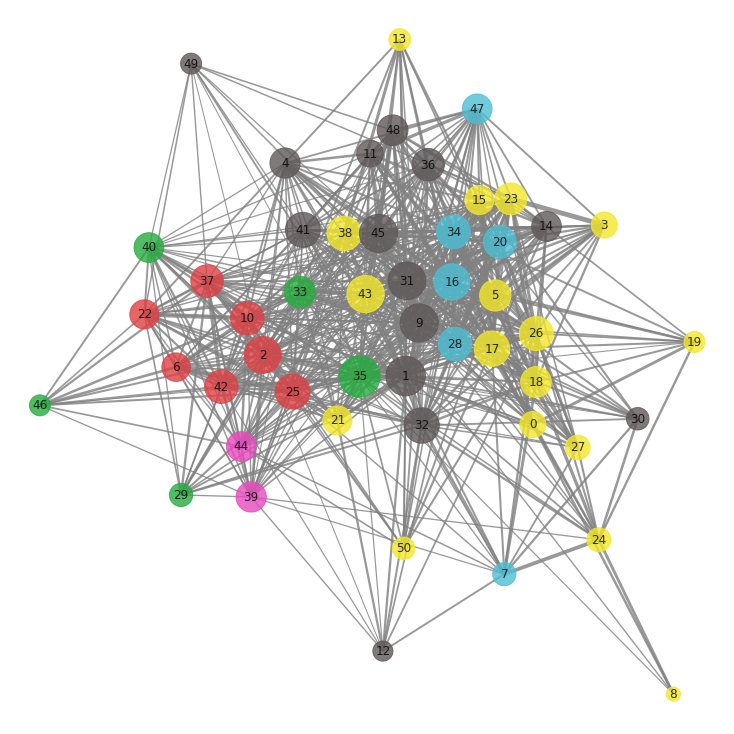

In [141]:
G, G_pos = get_net(cong_net, id_map=actor_id_map, layout_type='sp')
plot_pos_neg_net(G, G_pos, id_map=actor_id_map, node_scale=50, filename='Net/Congruence.png')

In [142]:
# Identifying actors
rev_map = actor_id_map.get_reverse_map()
rev_map[2]

{'name': 'Binding, Lothar', 'party': 'SPD'}

# Computing modularity

In [143]:
def partition_graph(net_adj, remove_node=None):
    
    # Generating the graph
    G = NetworkView.gen_simple_graph(net_adj)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    if remove_node is not None:
        G.remove_nodes_from(remove_node)
        
    partition = community.best_partition(G)
    print('No. of partitions = ', float(len(set(partition.values()))))
    
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    print('Modularity score: ', community.modularity(partition, G))
    count = 0.
    plt.figure(figsize=(5,5))
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))


    nx.draw_networkx_edges(G, pos, alpha=0.5)

No. of partitions =  4.0
Modularity score:  0.23969990620845527


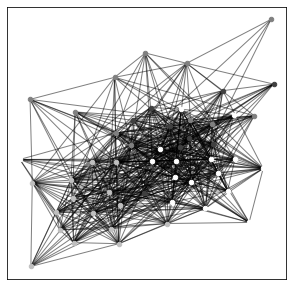

In [144]:
partition_graph(pos_net, remove_node=None)

# Computing clustering coefficient

In [145]:
G, pos = get_net(cong_net)
g_cluster = nx.average_clustering(G)
print(f'Cluster avg.: {g_cluster}')

Cluster avg.: 0.7253429178035283


# Computing E-I index

In [146]:
def compute_EI_index(cong_net, actor_id_map, internal=['CDU'], verbose=False):
    """
    Function computes the External Intrenal index
    
    Parameters:
        cong_net : The congruence network
        actor_id_map : A mapping definition for the rows
        internal : Indicates which actors should be considered a group
    """
    if verbose:
        print('Internal group: ', internal)
    
    internal_mask = np.zeros(actor_id_map.get_len())
        
    for k, val in actor_id_map.map.items():
        is_internal = val.get('party') in internal
        actor_id = val.get('id')
        val['internal'] = is_internal
        actor_id_map.map[k] = val
        internal_mask[actor_id] = int(is_internal)
        
    if verbose:
        print('internal_mask')
        print(internal_mask)
        
    EL = 0
    IL = 0
    
    for i, row in enumerate(cong_net):
        if not internal_mask[i]:
            continue
            
        row = row > 0
        row = row.astype(int)
        
        internal_edge = row * internal_mask
        external_edge = row * (internal_mask == 0)
        
        IL += int(sum(internal_edge))
        EL += int(sum(external_edge))
    
    # Swapping signs
    index = - (EL - IL) / (EL + IL)
    
    print('EL: ', EL)
    print('IL: ', IL)
    print('EL/IL Index: ', index)
    return index

In [147]:
compute_EI_index(cong_net, actor_id_map, internal=['CDU', 'CSU', 'FDP'])

EL:  213
IL:  720
EL/IL Index:  0.5434083601286174


0.5434083601286174